**Course**:    Social graphs and interactions

**No.**:       02805

**Students**:  s204255 & s204122

**Date**:      11th December 2024



# Imports

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load statics

In [2]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [3]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [4]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

In [5]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

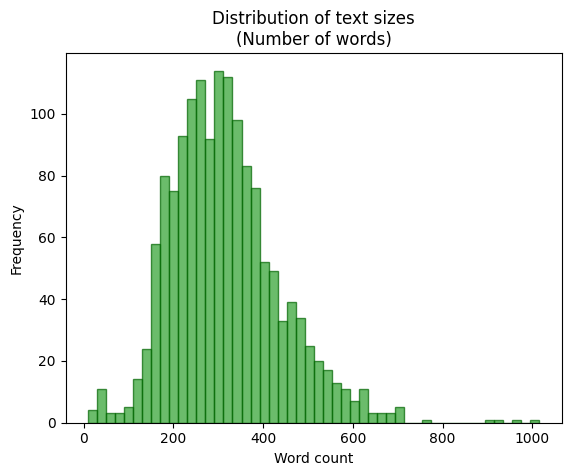

In [6]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7, edgecolor='darkgreen')
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [7]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [8]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])
# Remove nodes from G with empty evaluation scores
G = G.subgraph([node for node in G.nodes if G.nodes[node]['eval_scores']])

# Degree distribution

# Plotting

## Test partitionings

In [9]:
import networkx as nx
from collections import Counter, defaultdict
import random

def overlapping_label_propagation(graph, max_size, max_iterations=100):
    """
    Overlapping Label Propagation Algorithm with size constraints.

    Parameters:
        graph (nx.Graph): The input graph.
        max_size (int): The maximum allowable size for a community.
        max_iterations (int): Maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are community indices (starting from 0) and values are lists of nodes.
    """
    # Initialize each node with its own unique label as a set
    labels = {node: {node} for node in graph.nodes}
    
    for iteration in range(max_iterations):
        changes = False
        
        # Randomize node order to reduce bias
        nodes = list(graph.nodes)
        random.shuffle(nodes)
        
        for node in nodes:
            # Collect all labels from neighbors
            neighbor_labels = []
            for neighbor in graph.neighbors(node):
                neighbor_labels.extend(labels[neighbor])  # Collect labels of neighbors
            
            # Count the frequency of each label in the neighborhood
            label_counts = Counter(neighbor_labels)
            
            # Sort labels by frequency (descending) and resolve ties randomly
            sorted_labels = sorted(label_counts.items(), key=lambda x: (-x[1], random.random()))
            
            # Add labels while respecting size constraints
            current_labels = labels[node]
            for label, _ in sorted_labels:
                community_size = sum(1 for n in graph.nodes if label in labels[n])
                if community_size < max_size and label not in current_labels:
                    current_labels.add(label)
                    changes = True
            
        # Stop if no labels were changed
        if not changes:
            break
    
    # Create a community dictionary with sequential indices
    community_dict = defaultdict(list)
    label_to_index = {}  # Map original labels to indices
    current_index = 0
    
    for node, node_labels in labels.items():
        for label in node_labels:
            if label not in label_to_index:
                label_to_index[label] = current_index
                current_index += 1
            community_dict[label_to_index[label]].append(node)
    
    return dict(community_dict)



In [10]:
def heuristic_pm_2(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Predecessors and the predecessors of predecessors
    3. Successors and the successors of successors 
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add predecessors and their predecessors
        for pred in graph.predecessors(node):
            community.add(pred)
            community.update(graph.predecessors(pred))
        
        # Add successors and their successors
        for succ in graph.successors(node):
            community.add(succ)
            community.update(graph.successors(succ))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 15 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 15}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)
    
    # replace nodes with indeces
    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


def heuristic_pm_1(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Immediate predecessors
    3. Immediate successors
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add immediate predecessors
        community.update(graph.predecessors(node))
        
        # Add immediate successors
        community.update(graph.successors(node))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 9 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 9}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)

    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


In [11]:
# Method 1 - Ordinary label propagation
from networkx.algorithms.community import label_propagation_communities
H = G.to_undirected()
communities = label_propagation_communities(H)

In [12]:
# Method 2 - Overlapping label propagation with size constraints
H = G.to_undirected()
communities = overlapping_label_propagation(H, 6)

In [13]:
# Method 3 - Overlapping label propagation with size constraints and degree filtering
H = G.to_undirected()
for node in G.nodes:
    if G.out_degree(node) > 10:
        H.remove_node(node)  
communities = overlapping_label_propagation(H, 6)

In [14]:
# Method 4 - Heuristic ± 1 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_1(H)

In [15]:
# Method 5 - Heuristic ± 2 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_2(H)

# Analyse words in communities

In [16]:
from evaluation import generate_wordcloud

# Download stopwords if you haven't already
nltk.download('stopwords')

# Get the list of English stopwords from nltk
nltk_stopwords = set(stopwords.words("english"))

# Define your own custom stopwords
with open("stopwords.txt", "r") as file:
    custom_stopwords = {line.strip() for line in file}

# Combine nltk stopwords with your custom stopwords
stop_words = nltk_stopwords.union(custom_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stein\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Sort the communities by the number of values (courses) in descending order
sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

# Take the top 10 items
top_10_communities = dict(sorted_communities[:10])


In [19]:
top_10_communities

{52: ['02110',
  '01019',
  '02157',
  '02403',
  '02100',
  '02402',
  '01001',
  '01004',
  '02105',
  '02405',
  '02326',
  '01002',
  '01003',
  '02141',
  '02249'],
 56: ['01019',
  '02157',
  '02100',
  '02135',
  '01001',
  '02156',
  '01904',
  '01017',
  '02105',
  '02003',
  '02158',
  '02002',
  '02263',
  '02132',
  '02141'],
 64: ['02291',
  '02161',
  '01019',
  '02157',
  '02110',
  '02100',
  '02808',
  '02170',
  '01001',
  '02830',
  '38110',
  '01017',
  '02105',
  '02266',
  '02141'],
 85: ['02421',
  '01035',
  '02403',
  '02417',
  '02402',
  '01001',
  '02405',
  '02525',
  '01002',
  '01003',
  '01004',
  '28020',
  '34721',
  '28150',
  '28160'],
 96: ['02403',
  '02409',
  '02450',
  '02402',
  '01001',
  '02477',
  '02405',
  '02456',
  '02525',
  '02460',
  '01002',
  '01003',
  '01004',
  '02002',
  '02476'],
 100: ['02403',
  '02450',
  '02402',
  '01001',
  '02830',
  '02464',
  '02462',
  '02525',
  '01002',
  '01003',
  '01004',
  '02002',
  '02461',
  

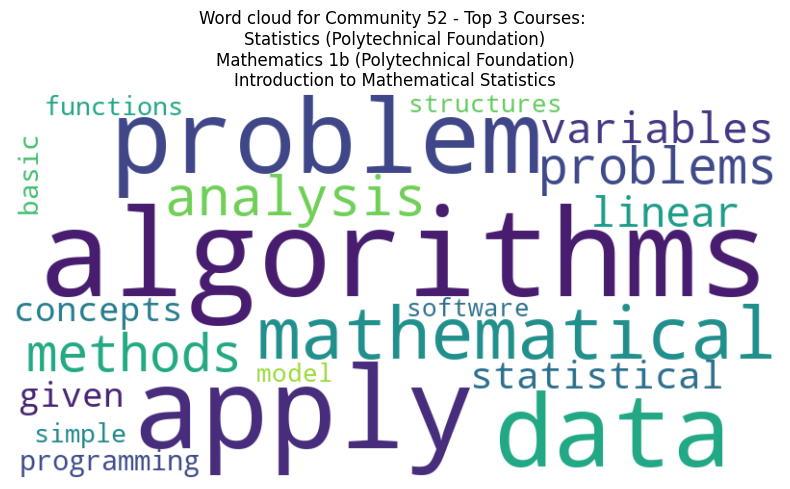

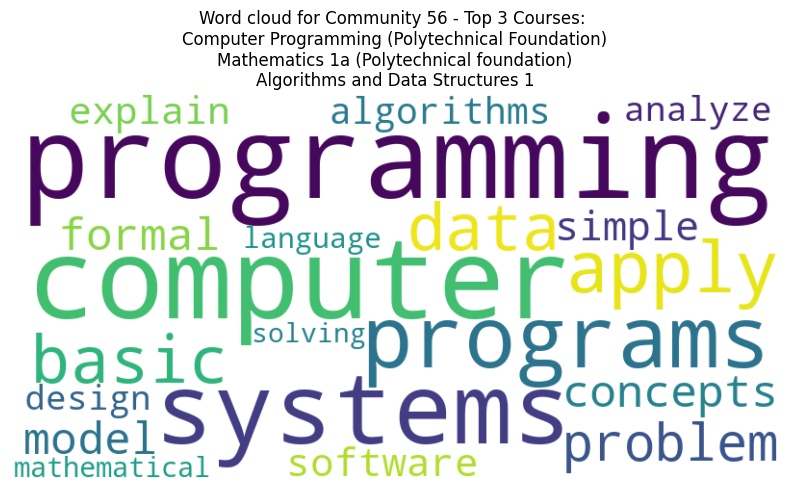

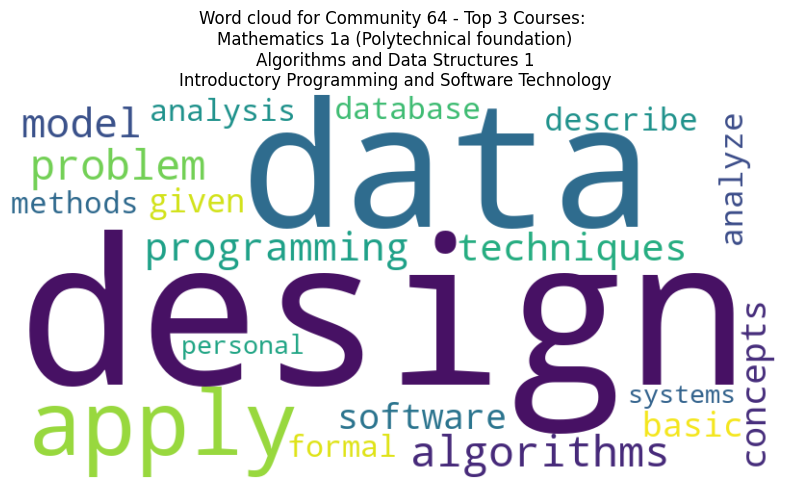

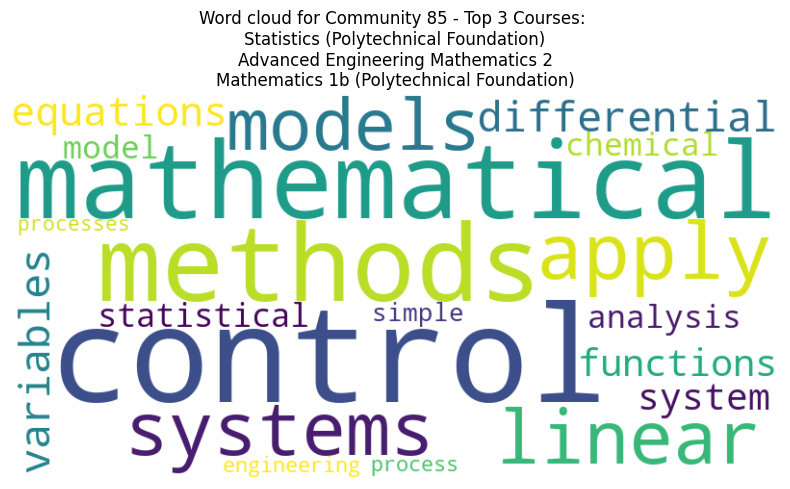

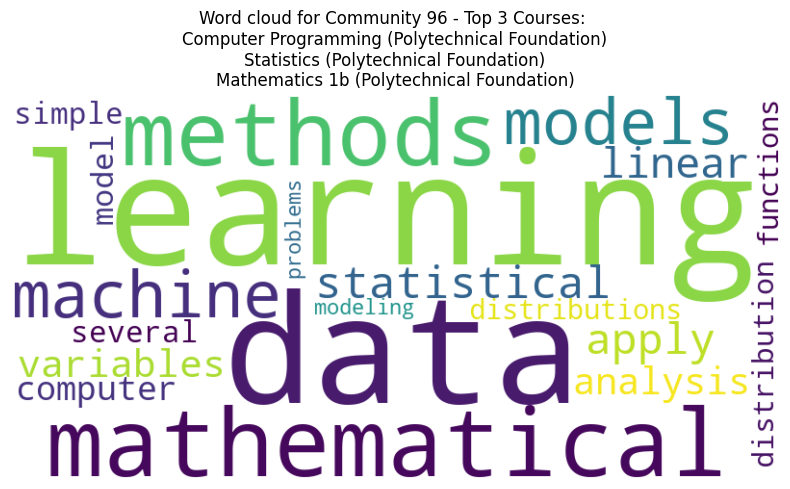

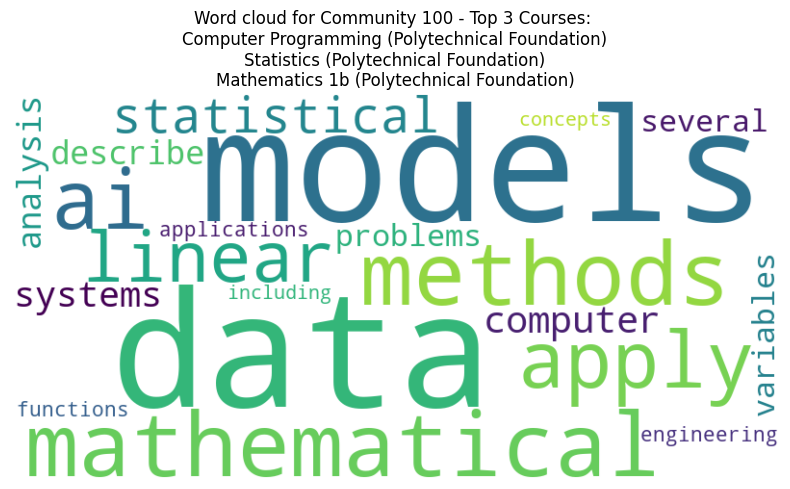

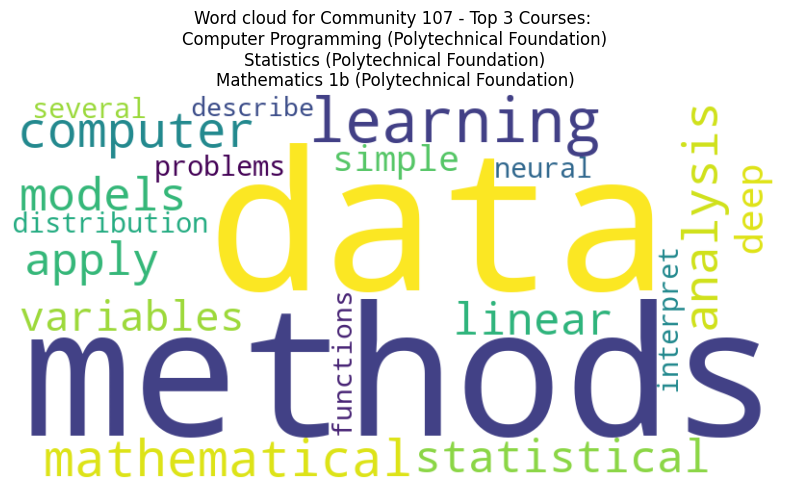

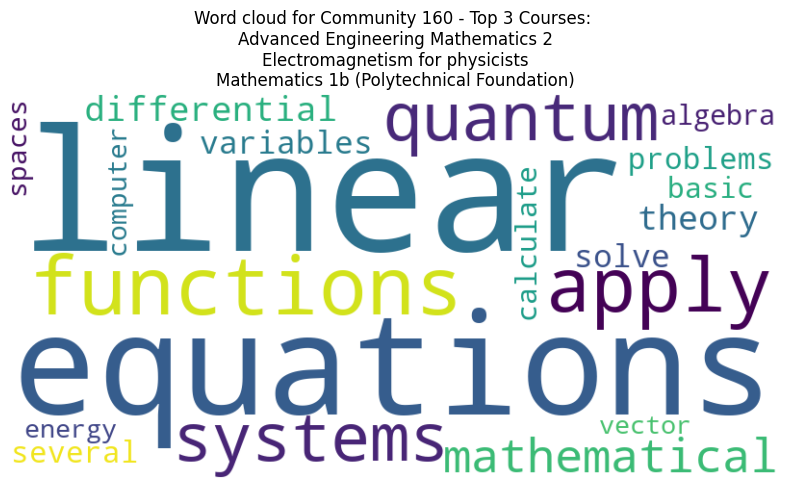

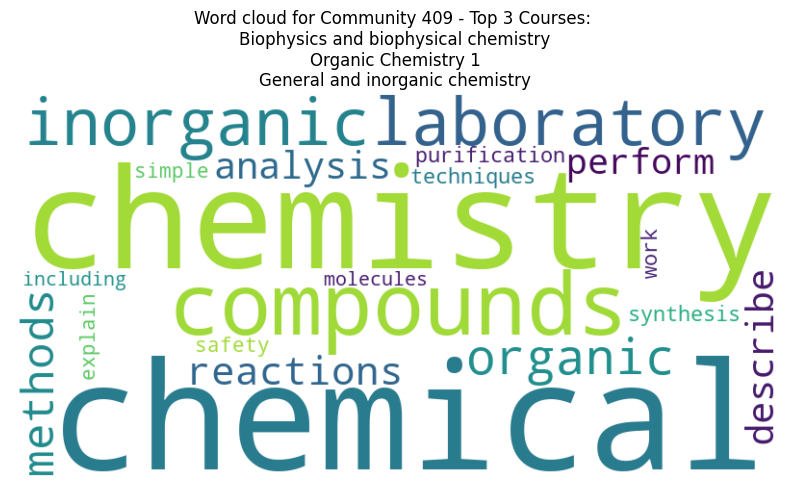

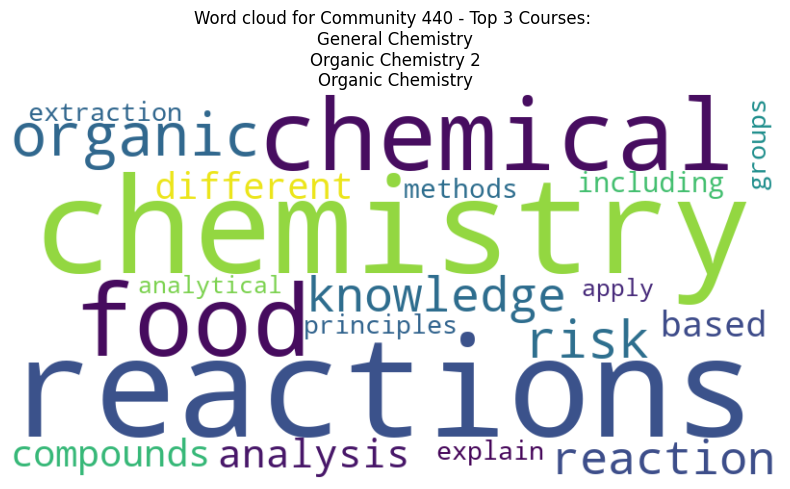

In [18]:
P = G.copy()
generate_wordcloud(P,top_10_communities, stop_words, 20)